In [1]:
import pandas as pd
import os
from pathlib import Path
import Data
import coordinates

In [2]:
currpath = os.getcwd()
mypath = Path().absolute().parent # each '.parent' goes one level up - vary as required
#print(mypath)
#os.chdir(mypath)
os.chdir(os.path.dirname(os.path.abspath("meuse_data.csv")))
print(Path().absolute())

C:\Users\chloe\OneDrive\AY2024 FYP\FYP-Code\FYP-Spatial-Analytics


## Data Package Introduction

The meuse data set provided by package sp is a data set comprising of four heavy metals measured in the top soil in a flood plain along the river Meuse, along with a handful of covariates.

In [3]:
meuse_df = pd.read_csv("Data/meuse_data.csv")
df2 = meuse_df
df2.describe()

,x,y,cadmium,copper,lead,zinc,elev,dist,om,ffreq,soil,lime,dist.m
count,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,153.000000,155.000000,155.000000,155.000000,155.000000
mean,180004.600000,331634.935484,3.245806,40.316129,153.361290,469.716129,8.165394,0.240017,7.478431,1.606452,1.451613,0.283871,290.322581
std,746.039775,1047.746801,3.523746,23.680436,111.320054,367.073788,1.058657,0.197702,3.432966,0.734111,0.636483,0.452336,226.799927
min,178605.000000,329714.000000,0.200000,14.000000,37.000000,113.000000,5.180000,0.000000,1.000000,1.000000,1.000000,0.000000,10.000000
25%,179371.000000,330762.000000,0.800000,23.000000,72.500000,198.000000,7.546000,0.075687,5.300000,1.000000,1.000000,0.000000,80.000000
50%,179991.000000,331633.000000,2.100000,31.000000,123.000000,326.000000,8.180000,0.211843,6.900000,1.000000,1.000000,0.000000,270.000000
75%,180629.500000,332463.000000,3.850000,49.500000,207.000000,674.500000,8.955000,0.364067,9.000000,2.000000,2.000000,1.000000,450.000000
max,181390.000000,333611.000000,18.100000,128.000000,654.000000,1839.000000,10.520000,0.880389,17.000000,3.000000,3.000000,1.000000,1000.000000


In [4]:
import geoplot as gplt
import geopandas as gpd
import geoplot.crs as gcrs
import imageio
import matplotlib.pyplot as plt
import mapclassify as mc
import numpy as np
import shapely
import seaborn as sns

In [40]:
def get_outlier(dt, var):
    var_name = dt[var]
    original_data = var_name.copy()
    na1 = var_name.isna().sum()
    md1 = var_name.median(skipna=True)
    m1 = var_name.mean(skipna=True)

    # Plotting
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 2, 1)
    sns.boxplot(x=var_name)
    plt.title('With outliers')

    plt.subplot(2, 2, 2)
    sns.histplot(x=var_name, kde=True)
    plt.title('With outliers')

    # Identify outliers
    outlier = var_name[~var_name.between(var_name.quantile(0.25) - 1.5 * (var_name.quantile(0.75) - var_name.quantile(0.25)),
                                        var_name.quantile(0.75) + 1.5 * (var_name.quantile(0.75) - var_name.quantile(0.25)))]

    return outlier

Number of outliers: Zinc = 6, Copper = 7, Lead = 6, Cadmium = 15


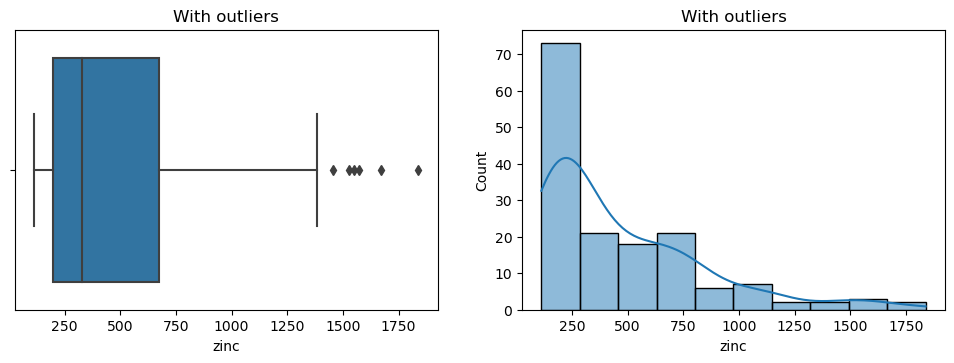

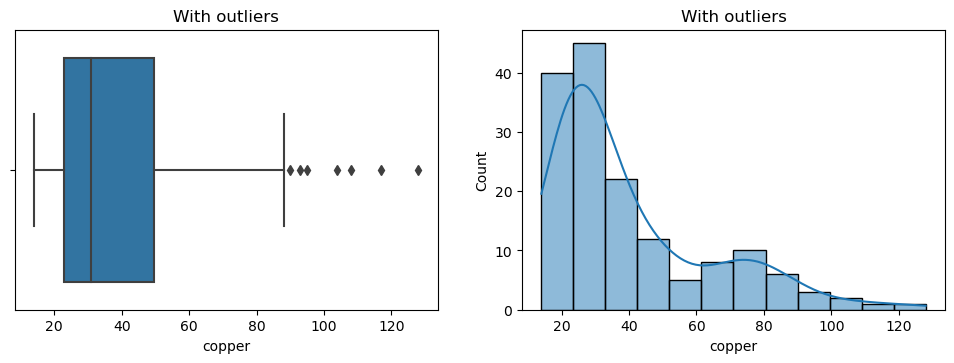

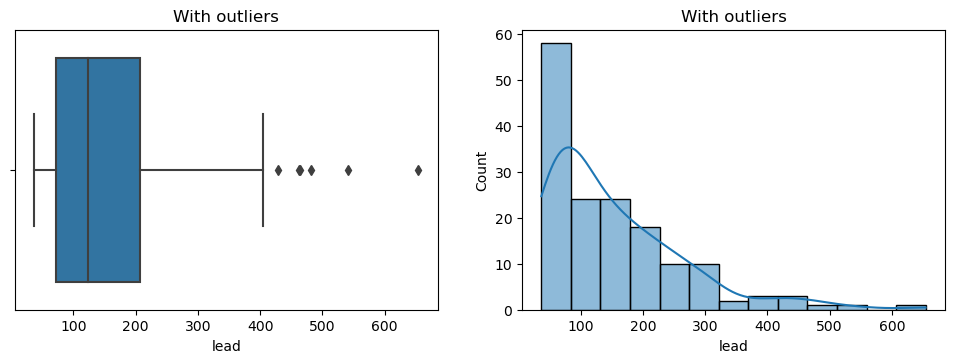

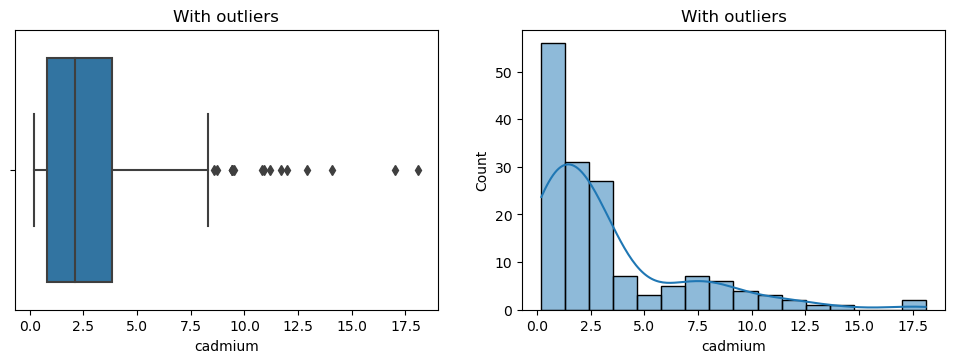

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Data = meuse_df.copy()
zinc_outliers = get_outlier(Data,'zinc')
copper_outliers = get_outlier(Data,'copper')
lead_outliers = get_outlier(Data,'lead')
cadmium_outliers = get_outlier(Data,'cadmium')

print(f"Number of outliers: Zinc = {len(zinc_outliers)}, Copper = {len(copper_outliers)}, Lead = {len(lead_outliers)}, Cadmium = {len(cadmium_outliers)}")

In [55]:
def remove_outlier(dt,var,outlier):
# Replace outliers with median
    var_name = dt[var]
    md_before = var_name.median(skipna=True)
    length = len(outlier)
    
    mo = outlier.mean()

    print("Proportion (%) of outliers:", (length / len(var_name)) * 100)
    print("Mean of the outliers:", round(mo, 2))
    
    cleaned_data = dt[~var_name.isin(outlier)]
    
    
    # Plotting
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 2, 1)
    sns.boxplot(x=cleaned_data[var])
    plt.title('Without outliers')

    plt.subplot(2, 2, 2)
    sns.histplot(x=cleaned_data[var], kde=True)
    plt.title('Without outliers')
    
    plt.suptitle('Outlier Check')
    
    md_after = cleaned_data[var].median(skipna=True)

    print("Median without removing outliers:", round(md_before, 2))
    print("Median if we remove outliers:", round(md_after, 2))

Proportion (%) of outliers: 3.870967741935484
Mean of the outliers: 1602.0
Median without removing outliers: 326.0
Median if we remove outliers: 298.0


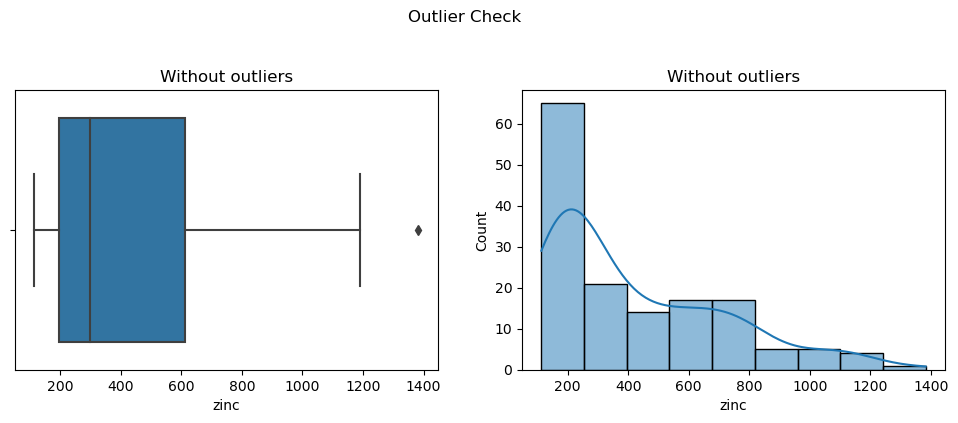

In [56]:
remove_outlier(Data,'zinc',zinc_outliers)

In [39]:
remove_outlier(Data,'copper',copper_outliers)
remove_outlier(Data,'lead',lead_outliers)
remove_outlier(Data,'cadmium',cadmium_outliers)

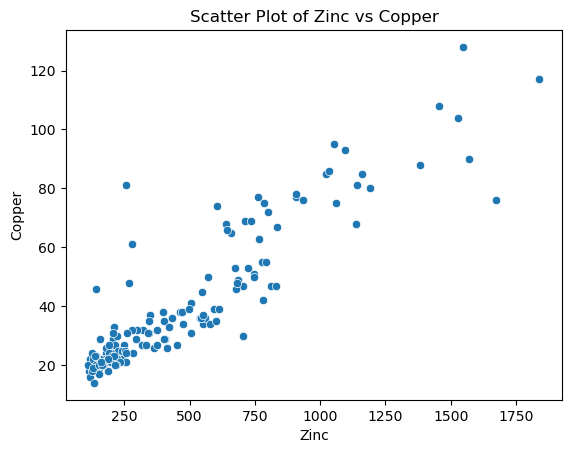

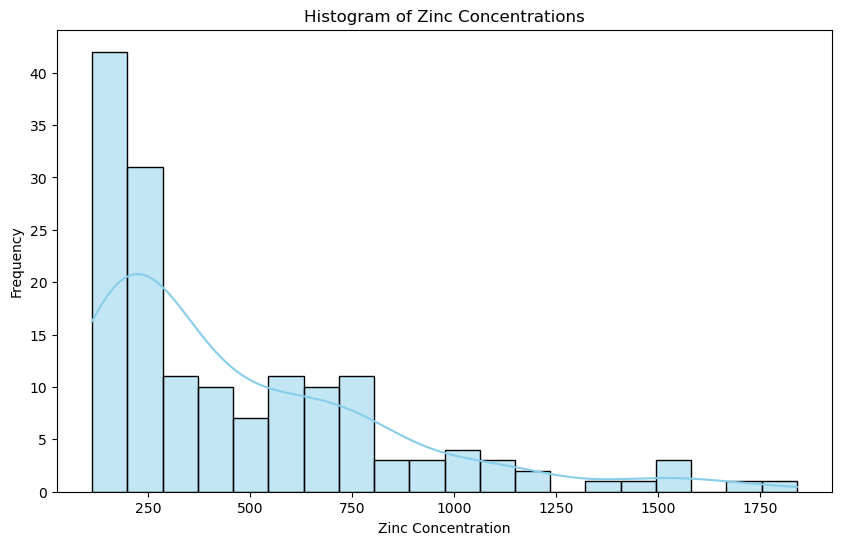

In [7]:
# Scatter plot of two variables (e.g., zinc and copper)
sns.scatterplot(x='zinc', y='copper', data=meuse_df)
plt.title('Scatter Plot of Zinc vs Copper')
plt.xlabel('Zinc')
plt.ylabel('Copper')
plt.show()

# Histogram of zinc concentrations
plt.figure(figsize=(10, 6))
sns.histplot(meuse_df['zinc'], bins=20, kde=True, color='skyblue')
plt.title('Histogram of Zinc Concentrations')
plt.xlabel('Zinc Concentration')
plt.ylabel('Frequency')
plt.show()

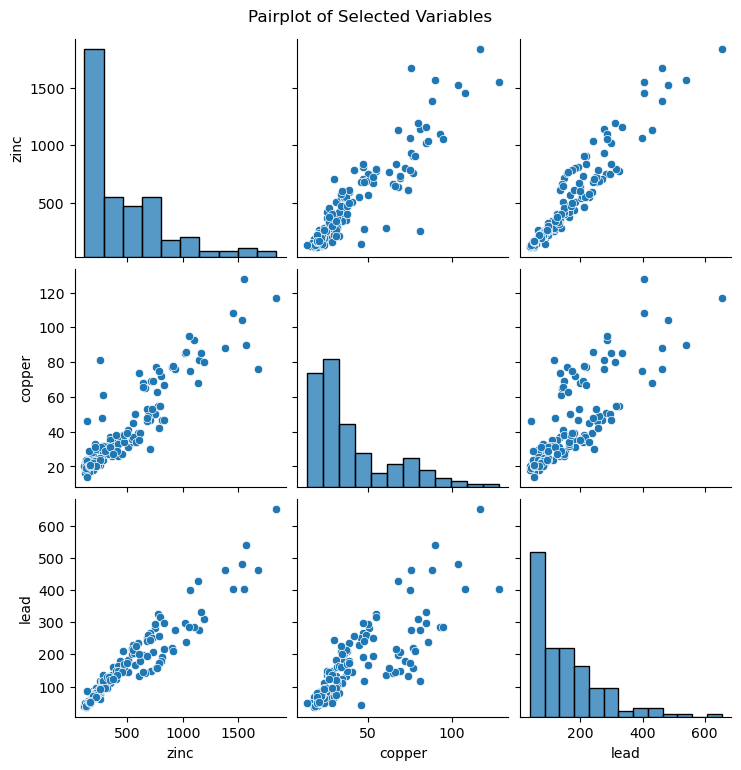

C:\Users\chloe\AppData\Local\Temp\ipykernel_33584\656115786.py:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = meuse_df.corr()


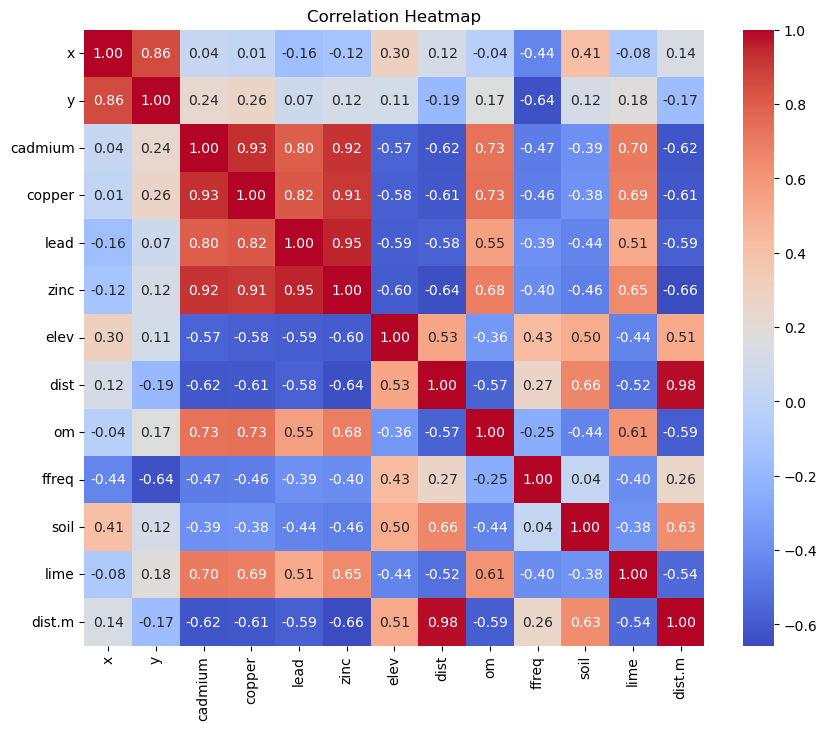

In [8]:
# Pairplot for selected variables (e.g., zinc, copper, and lead)
selected_vars = ['zinc', 'copper', 'lead']
sns.pairplot(meuse_df[selected_vars])
plt.suptitle('Pairplot of Selected Variables', y=1.02)
plt.show()

# Correlation heatmap for all numeric variables
correlation_matrix = meuse_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

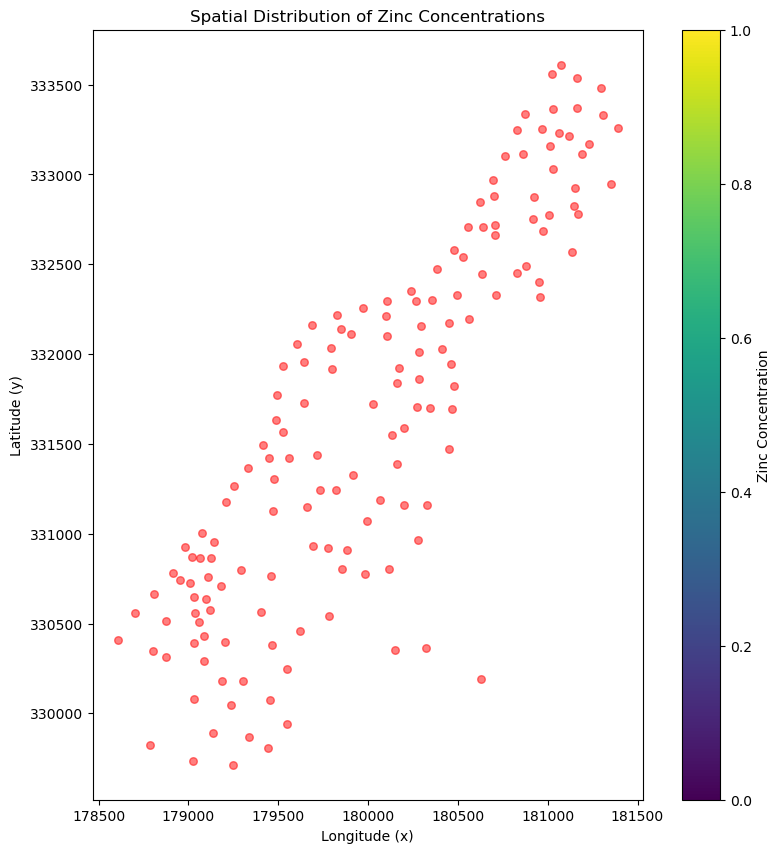

In [9]:
from shapely.geometry import Point

# Create a GeoDataFrame from the 'meuse' DataFrame
geometry = [Point(xy) for xy in zip(meuse_df['x'], meuse_df['y'])]
geo_df = gpd.GeoDataFrame(meuse_df, geometry=geometry)

# Plot the spatial distribution of zinc concentrations
fig, ax = plt.subplots(figsize=(10, 10))
geo_df.plot(ax=ax, marker='o', color='red', markersize=30, alpha=0.5)
ax.set_title('Spatial Distribution of Zinc Concentrations')
ax.set_xlabel('Longitude (x)')
ax.set_ylabel('Latitude (y)')

# Add colorbar for zinc concentrations
sc = plt.scatter([], [], c=[], cmap='viridis', label='Zinc Concentration')
plt.colorbar(sc, label='Zinc Concentration')

plt.show()

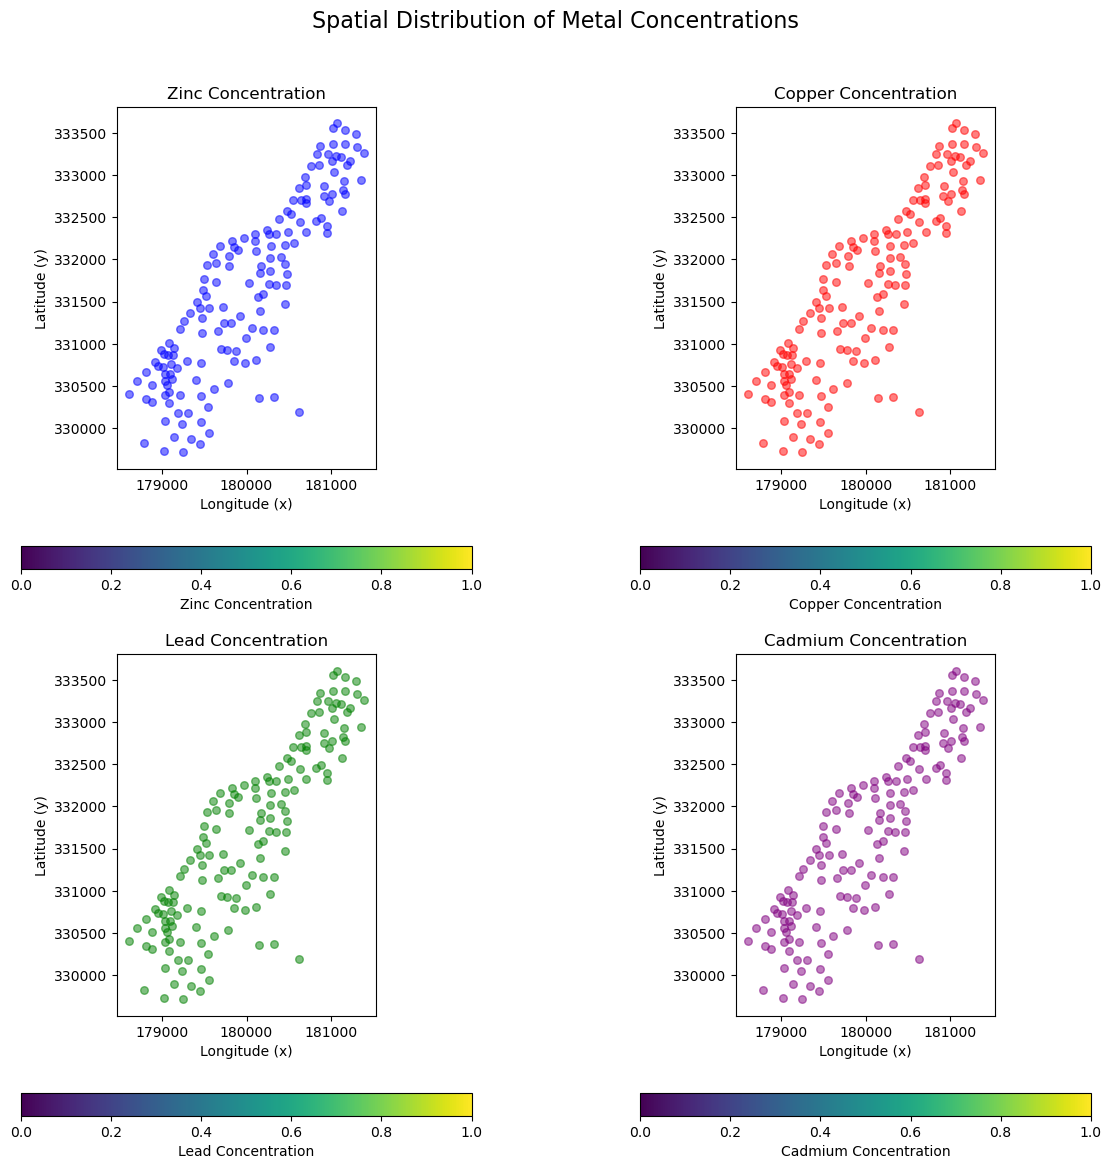

In [13]:
import geopandas as gpd
from shapely.geometry import Point

# Create a GeoDataFrame from the 'meuse' DataFrame
geometry = [Point(xy) for xy in zip(meuse_df['x'], meuse_df['y'])]
geo_df = gpd.GeoDataFrame(meuse_df, geometry=geometry)

# List of variables to plot
variables_to_plot = ['zinc', 'copper', 'lead', 'cadmium']
colors = ['blue','red','green','purple']

# Plot the spatial distribution of each variable
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle('Spatial Distribution of Metal Concentrations', fontsize=16)

for variable, color, ax in zip(variables_to_plot, colors, axes.flatten()):
    geo_df.plot(ax=ax, marker='o', color= color, markersize=30, alpha=0.5)
    ax.set_title(f'{variable.capitalize()} Concentration')
    ax.set_xlabel('Longitude (x)')
    ax.set_ylabel('Latitude (y)')

    # Add colorbar for the specific metal concentration
    sc = ax.scatter([], [], c=[], cmap='viridis', label=f'{variable.capitalize()} Concentration')
    fig.colorbar(sc, ax=ax, label=f'{variable.capitalize()} Concentration', location='bottom', shrink=0.6)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()